In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.feature_selection import mutual_info_classif

import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split#,cross_val_score
from sklearn.preprocessing import StandardScaler

# from catboost import CatBoostRegressor # < DO NOT UNCOMMENT ON A LOCAL MASHINE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor#, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 


/Users/aliona/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## READ DATA

In [2]:
# local only:
# df_test = pd.read_csv('test.csv')
# df_train = pd.read_csv('train.csv')
# df_sub = pd.read_csv('sample_submission.csv')


In [3]:
#local:
path = "ML/"
# remote:
#path = "/content/drive/My Drive/ML/"

# data =pd.read_csv(path + 'data_ML.csv')
# data = pd.read_csv('data_dum.csv')
data = df_train = pd.read_csv(path + 'data_noouts.csv')
# data = pd.read_csv(path + 'data_noouts_dum.csv')



In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69815 entries, 0 to 69814
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         69815 non-null  int64  
 1   model_name    69815 non-null  int64  
 2   body_type     69815 non-null  int64  
 3   doors         69815 non-null  int64  
 4   color         69815 non-null  int64  
 5   engine_V      69815 non-null  float64
 6   power         69815 non-null  float64
 7   fuel          69815 non-null  int64  
 8   mileage       69815 non-null  float64
 9   transmission  69815 non-null  int64  
 10  owners        69815 non-null  int64  
 11  pass          69815 non-null  int64  
 12  drive         69815 non-null  int64  
 13  wheel         69815 non-null  int64  
 14  price         69815 non-null  int64  
 15  test_train    69815 non-null  object 
 16  model_age     69815 non-null  float64
 17  new_model     69815 non-null  int64  
 18  car_age       69815 non-nu

In [6]:
data.isna().sum()


brand           0
model_name      0
body_type       0
doors           0
color           0
engine_V        0
power           0
fuel            0
mileage         0
transmission    0
owners          0
pass            0
drive           0
wheel           0
price           0
test_train      0
model_age       0
new_model       0
car_age         0
new_car         0
retro           0
raritet         0
electrocar      0
petrol_car      0
1_owner         0
dtype: int64

In [7]:
data[data["price"]==0]


,brand,model_name,body_type,doors,color,engine_V,power,fuel,mileage,transmission,...,test_train,model_age,new_model,car_age,new_car,retro,raritet,electrocar,petrol_car,1_owner
35129,8,299,9,4,2,0.79,4.66,4,11.21,0,...,test,2.08,0,2.08,0,0,0,0,1,0
35130,8,299,9,4,1,0.96,4.71,4,11.01,3,...,test,1.39,0,1.39,0,0,0,0,1,1
35131,8,332,9,4,6,1.03,5.03,4,11.39,0,...,test,2.08,0,2.08,0,0,0,0,1,1
35132,8,299,9,4,3,0.96,4.71,4,11.46,1,...,test,2.08,0,2.08,0,0,0,0,1,1
35133,8,299,9,4,14,1.03,5.03,4,10.98,1,...,test,2.56,0,2.56,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69810,1,449,0,4,6,1.39,5.52,0,2.30,1,...,test,0.69,0,0.69,0,0,0,0,0,1
69811,1,451,0,4,14,1.39,5.52,0,2.77,1,...,test,1.10,0,1.10,0,0,0,0,0,1
69812,1,2,19,3,14,1.10,5.25,0,2.77,1,...,test,1.10,0,1.10,0,0,0,0,0,1
69813,1,458,20,1,3,1.10,3.85,4,2.40,3,...,test,4.43,0,4.43,0,1,1,0,1,0


<AxesSubplot:>

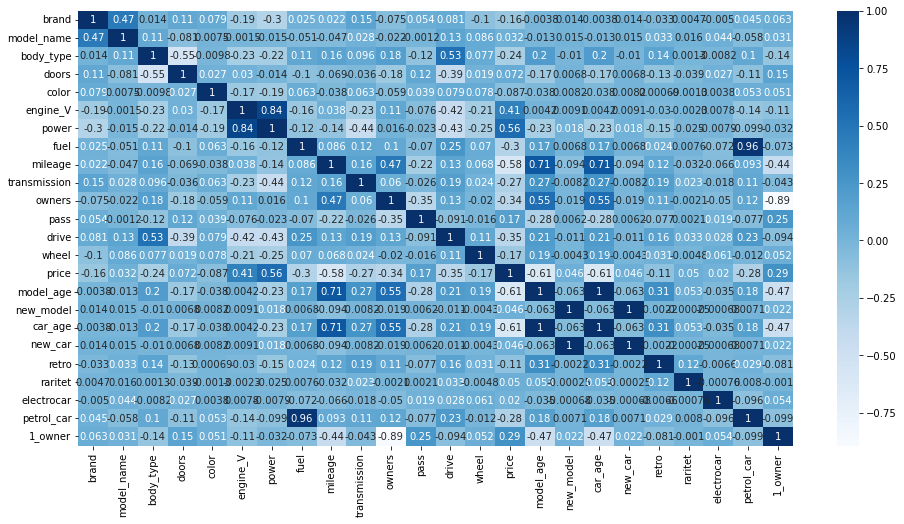

In [8]:
# heatmap 
plt.figure(figsize=(16,8))
sns.heatmap(data[data.test_train=="train"].corr(),annot=True, cmap="Blues")


#### Несколько выводов:
    Привод и количество дверей как-то зависят от типа кузова
    Цена сильно зависит (обратно) от пробега и возраста
    Пробег и возраст скореллированы
    Высокая корреляция присутствует между (model_age и car_age) и между (new_car и new_model) и (fuel и petrol_car) признаками 
Посмотрим на значимость признаков, уберем model_age и new_model





In [9]:
used_features = list(data.columns)
used_features.remove("test_train")
used_features.remove("price")
used_features


['brand',
 'model_name',
 'body_type',
 'doors',
 'color',
 'engine_V',
 'power',
 'fuel',
 'mileage',
 'transmission',
 'owners',
 'pass',
 'drive',
 'wheel',
 'model_age',
 'new_model',
 'car_age',
 'new_car',
 'retro',
 'raritet',
 'electrocar',
 'petrol_car',
 '1_owner']

<AxesSubplot:>

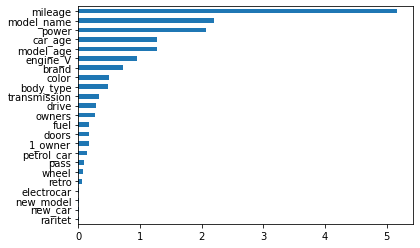

In [10]:
# посмотрим на значимость признаков:
imp_cat = pd.Series(mutual_info_classif(data[data['price']>0][used_features],
                                     data[data['price']>0]['price'],
                                     discrete_features = True), index=used_features)
#plt.figure(figsize=(15,15))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


 Самый важный признак - пробег, а также мощность, имя модели, возраст, объем двигателя, марка и цвет
 
 удалим  скореллированные признаки, так как на цену они влияют одинаково в данном датасете

In [11]:
data.drop(["model_age", 
           "new_model", 
           "petrol_car"#, 
          # "model_name"
          ], axis=1, inplace=True)


In [12]:
used_features.remove("model_age")
used_features.remove("petrol_car")
used_features.remove("new_model")
#used_features.remove("model_name")


## ML

разделяем датасеты

In [13]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69815 entries, 0 to 69814
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         69815 non-null  int64  
 1   model_name    69815 non-null  int64  
 2   body_type     69815 non-null  int64  
 3   doors         69815 non-null  int64  
 4   color         69815 non-null  int64  
 5   engine_V      69815 non-null  float64
 6   power         69815 non-null  float64
 7   fuel          69815 non-null  int64  
 8   mileage       69815 non-null  float64
 9   transmission  69815 non-null  int64  
 10  owners        69815 non-null  int64  
 11  pass          69815 non-null  int64  
 12  drive         69815 non-null  int64  
 13  wheel         69815 non-null  int64  
 14  price         69815 non-null  int64  
 15  test_train    69815 non-null  object 
 16  car_age       69815 non-null  float64
 17  new_car       69815 non-null  int64  
 18  retro         69815 non-nu

In [14]:
df_train = data[data.test_train == "train"].drop("test_train", axis=1)
df_test = data[data.test_train == "test"].drop(['price', 'test_train'], axis=1)
len(df_test)

34686

Назначаем целевую переменную и производим разбивку train данных

In [15]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Построим модели и посчитаем предсказания, где возможно локально, где нет - на colab

## 1. Наивная модель

In [16]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [17]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train


In [18]:
# Находим median по экземплярам enginepower в трейне и размечаем тест
predict = X_test['power'].map(
    tmp_train.groupby('power')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")


Точность наивной модели по метрике MAPE: 62.50%


### result:   
    data_ML: 66.57%
    data_noouts: 62.50%
    
    

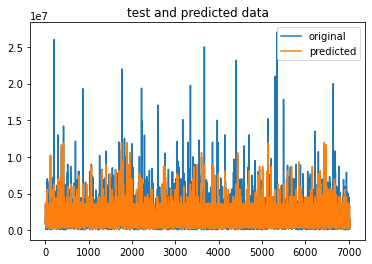

In [19]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

## 2. CatBoost

Столкнулась с неразрешимой проблемой на всех имеющихся во владении компьютерах

https://stackoverflow.com/questions/47022997/jupyter-the-kernel-appears-to-have-died-it-will-restart-automatically
    
на colab получился результат 

In [20]:
# y = df_train["price"]
# X = df_train.drop("price", axis=1)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)


In [21]:
# CBR = CatBoostRegressor(iterations=5000,
#                           random_seed=42,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                           )
# CBR.fit(X_train, y_train,
#           eval_set=(X_test, y_test),
#           verbose_eval=0,
#           use_best_model=True,
#           )

# CBR.save_model('catboost_single_model_baseline.model')


### result:
        data_ML: 14.94%
        data_noouts: 
        data_dum:
        data_noouts_dum:

### 3. LINEAR REGRESSION

In [22]:
y = df_train["price"]
X = df_train.drop("price", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [23]:
LR = LinearRegression().fit(X_train, np.log(y_train+1))
predict_LR = np.exp(LR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_LR))*100:0.2f}%")



Точность модели по метрике MAPE: 26.58%


### result:
        data_ML: 28.00%
        data_noouts: 26.73%
        data_dum:
        data_noouts_dum:
        

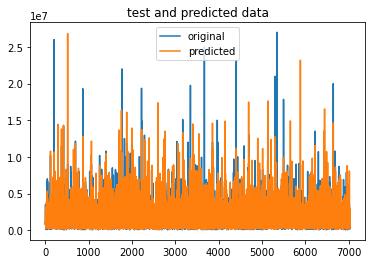

In [24]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_LR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


In [25]:
# Normalization:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
LRscaled = LinearRegression().fit(X_train, np.log(y_train+1))
predict_LRscaled = np.exp(LRscaled.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_LRscaled))*100:0.2f}%")


Точность модели по метрике MAPE: 26.58%


Нормализация не уменьшила ошибку

### result:
        data_ML: 28.00%
        data_noouts: 26.73%
        data_dum:
        data_noouts_dum:

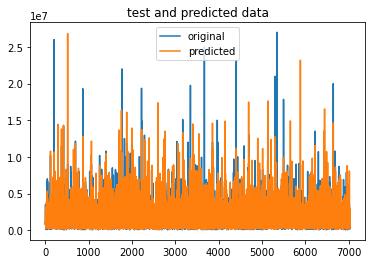

In [27]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_LRscaled, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 4.  Gradientboosting regressor

In [28]:
GBR = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=42)
GBR.fit(X_train, np.log(y_train+1))
predict_GBR = np.exp(GBR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_GBR))*100:0.2f}%")


Точность модели по метрике MAPE: 13.52%


### result:
        data_ML: 13.94%
        data_noouts: 13.69%
        data_dum:
        data_noouts_dum:

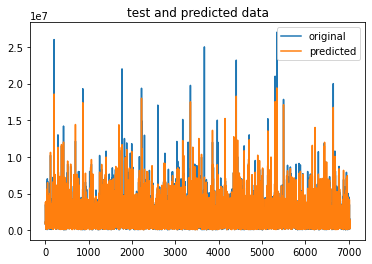

In [29]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_GBR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 4a.  XGBRegressor

In [30]:
import xgboost as xgb
XGBR = xgb.XGBRegressor(random_state=42, verbosity=0) 
XGBR.fit(X_train, np.log(y_train+1))
predict_XGBR = np.exp(XGBR.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_XGBR))*100:0.2f}%")


Точность модели по метрике MAPE: 14.05%


### result:
        data_ML: 
        data_noouts: 14.42%
        data_dum:
        data_noouts_dum:

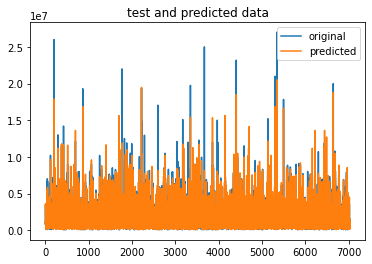

In [31]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, predict_XGBR, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()


### 5. LogisticRegression

целевая переменная не категориальная,  потому LogisticRegression не подходит 

### 6. Lazypredict

In [32]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)


In [33]:
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

### result:
        

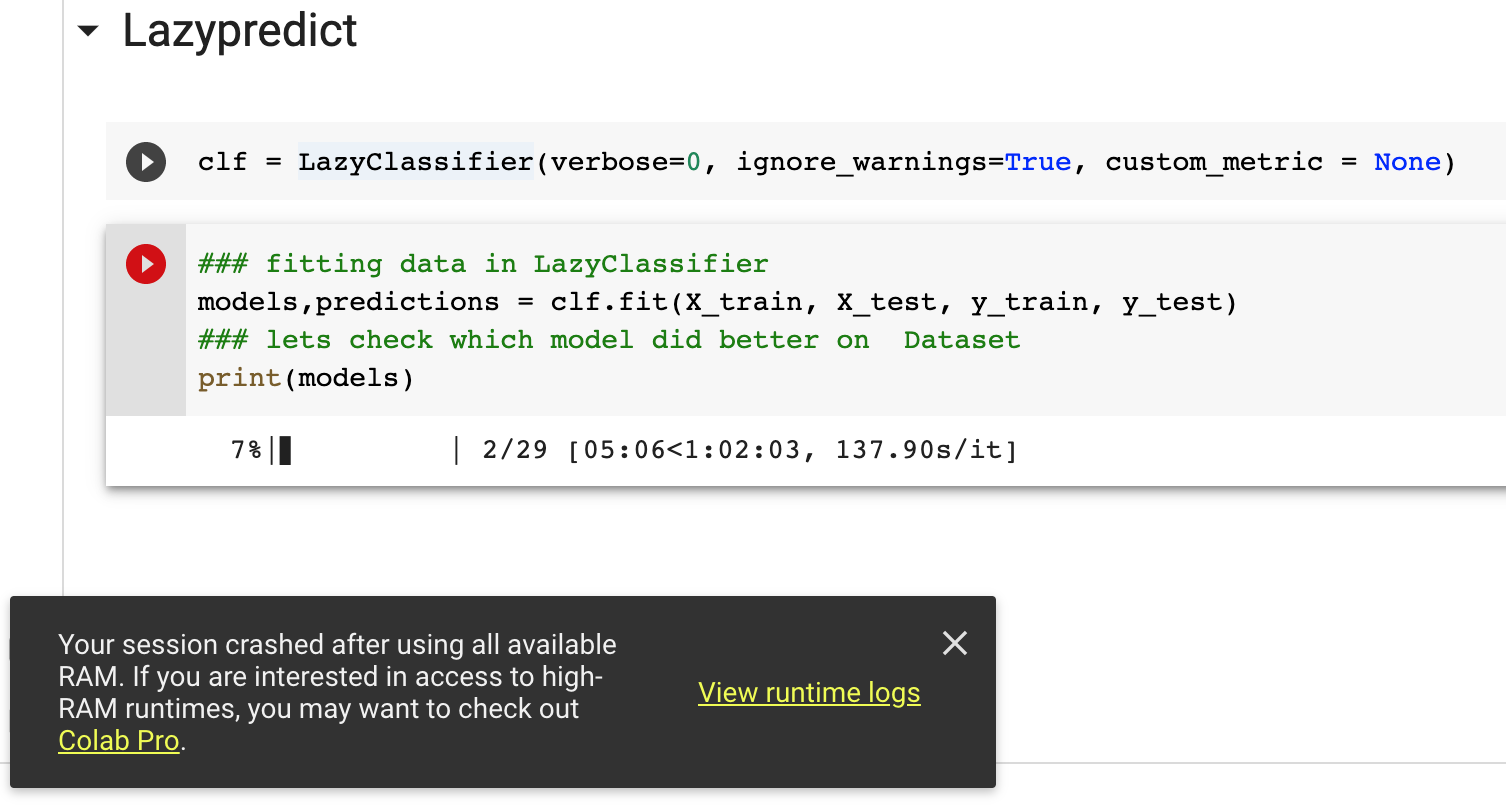

## Выбор модели (более общий вариант)



LinearRegression() :   MAPE = 26.58%


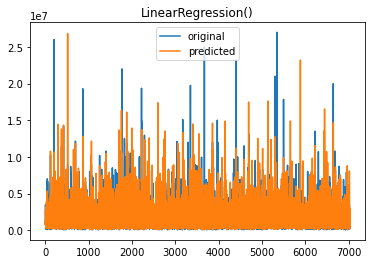






GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=300,
                          random_state=42) :   MAPE = 13.52%


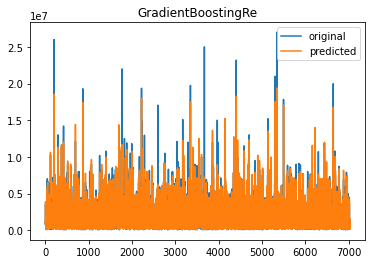






XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0) :   MAPE = 14.05%


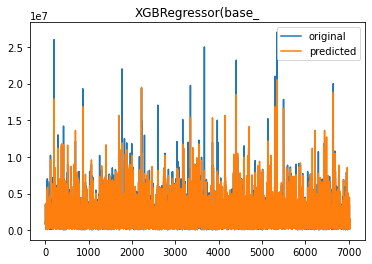

In [34]:
LR = LinearRegression()
GBR = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=42)
XGBR = xgb.XGBRegressor(random_state=42, verbosity=0) 


y = df_train["price"]
X = df_train.drop("price", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


models = [LR, GBR, XGBR]
for model in models:
    model.fit(X_train, np.log(y_train+1))
    y_pred = np.exp(model.predict(X_test))
    print("\n")                
    print(model,
    f":   MAPE = {(mape(y_test, y_pred))*100:0.2f}%")
    
    
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title(str(model)[:18])
    plt.legend()
    plt.show()
    print("\n\n")

## Стэкинг
За основу final_estimator возьмем алгоритм, предсказавший лучший результат - градиентный бустинг

In [35]:
# estimators = [('gbr',GradientBoostingRegressor(min_samples_split=2,
#                                                learning_rate=0.03,
#                                                max_depth=10,
#                                                n_estimators=300,
#                                                random_state=42)),
#               ('cbr', CatBoostRegressor(iterations = 5000,
#                                         random_state = 42,
#                                         eval_metric='MAPE',
#                                         silent=True))]


# final_estimator = GradientBoostingRegressor(random_state=42, 
#                                             max_depth=5, 
#                                             min_samples_split=3, 
#                                             n_estimators=1000)
# stack_reg = StackingRegressor(
#      estimators=estimators,
#      final_estimator=final_estimator)
# stack_reg.fit(X_train, np.log(y_train+1))

# predict_stack_reg = np.exp(stack_reg.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE: {(mape(y_test, predict_stack_reg))*100:0.2f}%")


### result:
    data_ML: 14.49%
    data_noouts:
    data_dum:
    data_noouts_dum

## 2...

In [36]:
# estimators = [('xgb', XGBRegressor(random_state=42, 
#                                    verbosity=0)),
#               ('cbr', CatBoostRegressor(iterations = 5000,
#                        random_state = 42,
#                        eval_metric='MAPE',
#                         silent=True)),
# ]
# final_estimator = GradientBoostingRegressor(random_state=42, 
#                                             max_depth=5, 
#                                             min_samples_split=3, 
#                                             n_estimators=1000)
# reg = StackingRegressor(
#      estimators=estimators,
#      final_estimator=final_estimator)
# reg.fit(X_train, np.log(y_train+1))
# print(
#     f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(reg.predict(X_test))))*100:0.2f}%")


## SUBMISSION

In [44]:
sample_submission = pd.read_csv('sample_submission.csv')
len(sample_submission)

34686

In [37]:
X_train[0]


array([  8.        , 343.        ,   9.        ,   4.        ,
        14.        ,   0.95551145,   4.63472899,   4.        ,
        12.19096408,   3.        ,   0.        ,   1.        ,
         1.        ,   0.        ,   3.09104245,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ])

In [38]:
df_test.values[0]


array([  8.        , 299.        ,   9.        ,   4.        ,
         2.        ,   0.78845736,   4.66343909,   4.        ,
        11.21183389,   0.        ,   2.        ,   1.        ,
         1.        ,   0.        ,   2.07944154,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

обучим модель на всей тестовой выборке

In [39]:
# stack_reg.fit(X, np.log(Y+1))
GBR.fit(X, np.log(y+1))


GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=300,
                          random_state=42)

In [45]:
predict_submission = np.round(
    np.exp(
        GBR.predict(df_test.values)
    ), -3).astype('int')

In [46]:
predict_submission[0:10]

array([ 793000, 1396000, 1707000, 1078000,  946000,  934000,  884000,
        494000, 2417000, 1046000])

In [47]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)


,sell_id,price
0,1100575026,793000
1,1100549428,1396000
2,1100658222,1707000
3,1100937408,1078000
4,1101037972,946000
5,1100912634,934000
6,1101228730,884000
7,1100165896,494000
8,1100768262,2417000
9,1101218501,1046000
